# Urban Sounds - Exploratory Data Analysis

## Import lib

In [24]:
!pip install mutagen

In [25]:
import os
import pandas as pd
import mutagen
import mutagen.wave
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from google.colab import drive

In [44]:
def read_metadata():
    # Mount Google Drive
    drive.mount('/content/drive')

    # Define the path to the CSV file
    download_path = Path('/content/drive/My Drive/UrbanSound8K')

    # Read metadata file
    metadata_file = download_path/'metadata'/'UrbanSound8K.csv'
    df = pd.read_csv(metadata_file)

    return df

df = read_metadata()
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          dog_bark  
1           2  children_playing  
2           2  children_playing  
3           2  children_playing  
4           2  children_playing  
...       ...               ...  
8727        1          car_horn  
8728        1          car_horn  
8729        1          car_horn  
8730        1          car_horn  
8731        1          car_horn  

[8732 rows x 8 columns]

## Create dataset

In [45]:
def create_dataset_df(df):

    filepaths = []
    for i, row in df.iterrows():
        filepaths.append(os.path.join('/content/drive/My Drive/UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    df['filepath'] = filepaths
    return df

df = create_dataset_df(df)

In [46]:
df

slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  \
0           3          dog_bark   
1           2  children_playing   
2           2  children_playing   
3           2  children_playing   
4           2  children_playing   
...       ...               ...   
8727        1          car_horn   
8728        1          car_horn   
8729        1          car_horn   
8730        1          car_horn   
8731        1          car_horn   

                                               filepath  
0     /content/drive/My Drive/UrbanSound8K/audio/fol...  
1     /content/drive/My Drive/UrbanSound8K/audio/fol...  
2     /content/drive/My Drive/UrbanSound8K/audio/fol...  
3     /content/drive/My Drive/UrbanSound8K/audio/fol...  
4     /content/drive/My Drive/UrbanSound8K/audio/fol...  
...                                                 ...  
8727  /content/drive/My Drive/UrbanSound8K/audio/fol...  
8728  /content/drive/My Drive/UrbanSound8K/audio/fol...  
8729  /content/drive/My Drive/UrbanSound8K/audio/fol...  
8730  /content/drive/My Drive/UrbanSound8K/audio/fol...  
8731  /content/drive/My Drive/UrbanSound8K/audio/fol...  

[8732 rows x 9 columns]

### Display the labels distribution

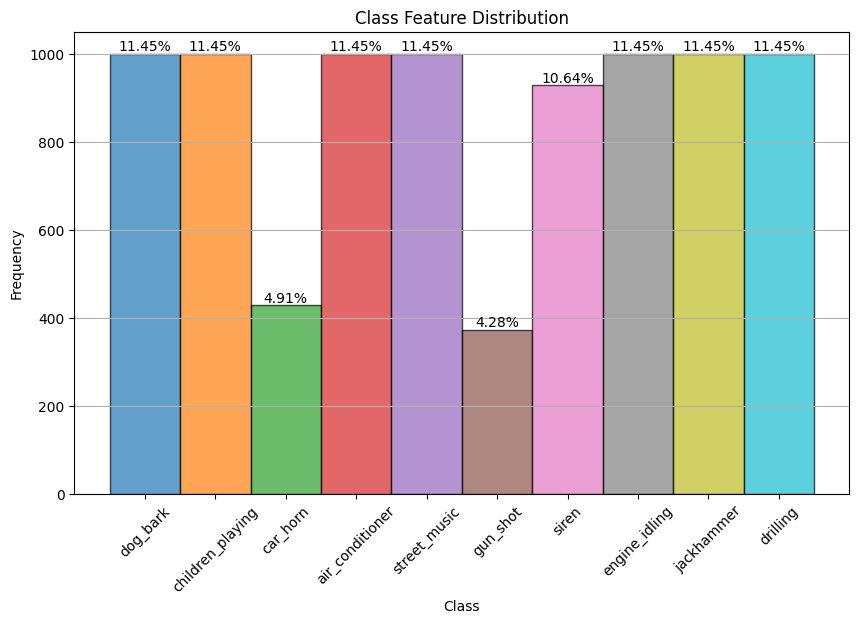

In [47]:
# Create the histogram for multi-label data
plt.figure(figsize=(10, 6))

# Define the labels and their respective colors
unique_labels = df["class"].unique()
colors = plt.cm.tab10(range(len(unique_labels)))  # Use a colormap for colors

# Plot the histogram
n, bins, patches = plt.hist(df["class"], bins=len(unique_labels), edgecolor='k', alpha=0.7)

# Apply colors to the patches
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# Calculate and annotate percentages
total = len(df["class"])
for count, patch in zip(n, patches):
    percentage = (count / total) * 100
    plt.text(patch.get_x() + patch.get_width() / 2, count, f'{percentage:.2f}%', ha='center', va='bottom')

# Set the x-ticks to the center of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.xticks(bin_centers, unique_labels, rotation=45)

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Feature Distribution')
plt.grid(axis='y')
plt.show()

## Audio file statistics

In [48]:
def get_audio_metadata_mutagen(filepath):
    metadata = {}
    # download_path = Path('/content/drive/My Drive/')
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata


def compute_audio_statistics(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []}
    # Extract metadata
    i = 0
    for filepath in dataset_df['filepath']:
        metadata = get_audio_metadata_mutagen(filepath)
        i = i + 1
        print(i)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    # Add new columns to dataframe
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]

    return dataset_df

In [49]:
df = df[:2000]
df

slice_file_name    fsID  start        end  salience  fold  classID  \
0       100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1     100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2     100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3     100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4     100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   
...                  ...     ...    ...        ...       ...   ...      ...   
1995   147926-0-0-37.wav  147926   18.5  22.500000         1     2        0   
1996   147926-0-0-39.wav  147926   19.5  23.500000         1     2        0   
1997    147926-0-0-4.wav  147926    2.0   6.000000         1     2        0   
1998   147926-0-0-41.wav  147926   20.5  24.500000         1     2        0   
1999   147926-0-0-42.wav  147926   21.0  25.000000         1     2        0   

                 class                                           filepath  
0             dog_bark  /content/drive/My Drive/UrbanSound8K/audio/fol...  
1     children_playing  /content/drive/My Drive/UrbanSound8K/audio/fol...  
2     children_playing  /content/drive/My Drive/UrbanSound8K/audio/fol...  
3     children_playing  /content/drive/My Drive/UrbanSound8K/audio/fol...  
4     children_playing  /content/drive/My Drive/UrbanSound8K/audio/fol...  
...                ...                                                ...  
1995   air_conditioner  /content/drive/My Drive/UrbanSound8K/audio/fol...  
1996   air_conditioner  /content/drive/My Drive/UrbanSound8K/audio/fol...  
1997   air_conditioner  /content/drive/My Drive/UrbanSound8K/audio/fol...  
1998   air_conditioner  /content/drive/My Drive/UrbanSound8K/audio/fol...  
1999   air_conditioner  /content/drive/My Drive/UrbanSound8K/audio/fol...  

[2000 rows x 9 columns]

In [50]:
audio_statistics_df = compute_audio_statistics(df)
audio_statistics_df

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


<ipython-input-48-c7d908306e21>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[key] = metadata_dict[key]
<ipython-input-48-c7d908306e21>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[key] = metadata_dict[key]
<ipython-input-48-c7d908306e21>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

slice_file_name    fsID  start        end  salience  fold  classID  \
0       100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1     100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2     100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3     100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4     100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   
...                  ...     ...    ...        ...       ...   ...      ...   
1995   147926-0-0-37.wav  147926   18.5  22.500000         1     2        0   
1996   147926-0-0-39.wav  147926   19.5  23.500000         1     2        0   
1997    147926-0-0-4.wav  147926    2.0   6.000000         1     2        0   
1998   147926-0-0-41.wav  147926   20.5  24.500000         1     2        0   
1999   147926-0-0-42.wav  147926   21.0  25.000000         1     2        0   

                 class                                           filepath  \
0             dog_bark  /content/drive/My Drive/UrbanSound8K/audio/fol...   
1     children_playing  /content/drive/My Drive/UrbanSound8K/audio/fol...   
2     children_playing  /content/drive/My Drive/UrbanSound8K/audio/fol...   
3     children_playing  /content/drive/My Drive/UrbanSound8K/audio/fol...   
4     children_playing  /content/drive/My Drive/UrbanSound8K/audio/fol...   
...                ...                                                ...   
1995   air_conditioner  /content/drive/My Drive/UrbanSound8K/audio/fol...   
1996   air_conditioner  /content/drive/My Drive/UrbanSound8K/audio/fol...   
1997   air_conditioner  /content/drive/My Drive/UrbanSound8K/audio/fol...   
1998   air_conditioner  /content/drive/My Drive/UrbanSound8K/audio/fol...   
1999   air_conditioner  /content/drive/My Drive/UrbanSound8K/audio/fol...   

        length  bitrate  channels  sample_rate  bits_per_sample  
0     0.317551  1411200         2        44100               16  
1     4.000000  1411200         2        44100               16  
2     4.000000  1411200         2        44100               16  
3     4.000000  1411200         2        44100               16  
4     4.000000  1411200         2        44100               16  
...        ...      ...       ...          ...              ...  
1995  4.000000  2116800         2        44100               24  
1996  4.000000  2116800         2        44100               24  
1997  4.000000  2116800         2        44100               24  
1998  4.000000  2116800         2        44100               24  
1999  4.000000  2116800         2        44100               24  

[2000 rows x 14 columns]

In [51]:
audio_statistics_df.describe()

fsID        start          end     salience         fold  \
count    2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean   115516.149000    34.462350    38.150132     1.265000     5.387000   
std     29434.261664    69.599955    69.692708     0.441444     2.820498   
min     11722.000000     0.000000     0.261224     1.000000     1.000000   
25%    105029.000000     3.500000     7.306557     1.000000     3.000000   
50%    118278.000000    10.000000    13.994276     1.000000     5.000000   
75%    135160.000000    31.133479    34.551082     2.000000     8.000000   
max    147926.000000   534.628805   538.628805     2.000000    10.000000   

          classID       length       bitrate     channels   sample_rate  \
count  2000.00000  2000.000000  2.000000e+03  2000.000000   2000.000000   
mean      4.75700     3.687096  1.758314e+06     1.908500  48986.350000   
std       2.83319     0.881551  8.093881e+05     0.288391  14081.103736   
min       0.00000     0.190000  2.560000e+05     1.000000  16000.000000   
25%       3.00000     4.000000  1.411200e+06     2.000000  44100.000000   
50%       5.00000     4.000000  1.411200e+06     2.000000  44100.000000   
75%       7.00000     4.000000  2.116800e+06     2.000000  48000.000000   
max       9.00000     4.000000  4.608000e+06     2.000000  96000.000000   

       bits_per_sample  
count      2000.000000  
mean         18.480000  
std           3.803266  
min           8.000000  
25%          16.000000  
50%          16.000000  
75%          24.000000  
max          24.000000

In [52]:
audio_statistics_df['sample_rate'].value_counts(), audio_statistics_df['bits_per_sample'].value_counts()

(sample_rate
 44100    1285
 48000     540
 96000     157
 16000      14
 22050       4
 Name: count, dtype: int64,
 bits_per_sample
 16    1356
 24     632
 8       12
 Name: count, dtype: int64)

In [53]:
audio_statistics_df.groupby('class').describe()

fsID                                                   \
                  count           mean           std       min       25%   
class                                                                      
air_conditioner   261.0  120291.272031  38664.886423   13230.0  101729.0   
car_horn           42.0  123148.142857  21388.427354   14524.0  118496.0   
children_playing  169.0  113025.159763  35181.356734   13579.0  104421.0   
dog_bark          196.0  108175.357143  31369.561067   11722.0  105088.0   
drilling          197.0  113059.411168  34896.542205   14110.0  104625.0   
engine_idling     360.0  118314.405556  18458.118980   12812.0  106015.0   
gun_shot          121.0  136832.355372   7056.570078  102305.0  135527.0   
jackhammer        229.0  109266.537118  23088.168980   14772.0  104998.0   
siren             196.0  115417.566327   9771.789073  102853.0  107357.0   
street_music      229.0  109580.554585  37549.329310   14385.0  108357.0   

                                                start              ...  \
                       50%       75%       max  count        mean  ...   
class                                                              ...   
air_conditioner   134717.0  146714.0  147926.0  261.0   12.833333  ...   
car_horn          128465.0  132073.0  145577.0   42.0   15.383021  ...   
children_playing  129356.0  135776.0  143651.0  169.0   19.973607  ...   
dog_bark          115850.0  122199.0  147672.0  196.0    9.243989  ...   
drilling          118440.0  135849.0  147764.0  197.0   38.352337  ...   
engine_idling     113202.0  128160.0  146186.0  360.0   20.695003  ...   
gun_shot          135528.0  136399.0  147317.0  121.0   21.453294  ...   
jackhammer        105029.0  125678.0  132021.0  229.0  115.919524  ...   
siren             112415.5  123688.0  135160.0  196.0   55.582958  ...   
street_music      115415.0  132108.0  147491.0  229.0   20.526030  ...   

                 sample_rate          bits_per_sample                       \
                         75%      max           count       mean       std   
class                                                                        
air_conditioner      44100.0  48000.0           261.0  20.750958  3.936424   
car_horn             48000.0  48000.0            42.0  17.523810  3.179493   
children_playing     48000.0  96000.0           169.0  17.514793  3.143600   
dog_bark             48000.0  96000.0           196.0  17.918367  3.424418   
drilling             48000.0  96000.0           197.0  18.192893  3.577616   
engine_idling        48000.0  96000.0           360.0  21.333333  3.776485   
gun_shot             48000.0  96000.0           121.0  16.925620  2.569583   
jackhammer           44100.0  48000.0           229.0  16.768559  2.362661   
siren                44100.0  48000.0           196.0  15.510204  1.922845   
street_music         44100.0  48000.0           229.0  18.096070  3.525525   

                                                
                   min   25%   50%   75%   max  
class                                           
air_conditioner   16.0  16.0  24.0  24.0  24.0  
car_horn          16.0  16.0  16.0  16.0  24.0  
children_playing  16.0  16.0  16.0  16.0  24.0  
dog_bark          16.0  16.0  16.0  16.0  24.0  
drilling          16.0  16.0  16.0  24.0  24.0  
engine_idling     16.0  16.0  24.0  24.0  24.0  
gun_shot          16.0  16.0  16.0  16.0  24.0  
jackhammer        16.0  16.0  16.0  16.0  24.0  
siren              8.0  16.0  16.0  16.0  16.0  
street_music      16.0  16.0  16.0  24.0  24.0  

[10 rows x 88 columns]

## Data Visualization

### Waveplots

First we can visualize the waveform for different random samples of each class

['/content/drive/My Drive/UrbanSound8K/audio/fold5/100852-0-0-12.wav', '/content/drive/My Drive/UrbanSound8K/audio/fold7/14524-1-0-0.wav', '/content/drive/My Drive/UrbanSound8K/audio/fold6/133494-2-0-18.wav', '/content/drive/My Drive/UrbanSound8K/audio/fold2/100652-3-0-3.wav', '/content/drive/My Drive/UrbanSound8K/audio/fold3/103199-4-0-6.wav', '/content/drive/My Drive/UrbanSound8K/audio/fold8/113203-5-2-0.wav', '/content/drive/My Drive/UrbanSound8K/audio/fold7/135527-6-14-8.wav', '/content/drive/My Drive/UrbanSound8K/audio/fold8/125678-7-0-2.wav', '/content/drive/My Drive/UrbanSound8K/audio/fold2/102871-8-0-10.wav', '/content/drive/My Drive/UrbanSound8K/audio/fold9/14385-9-0-17.wav']


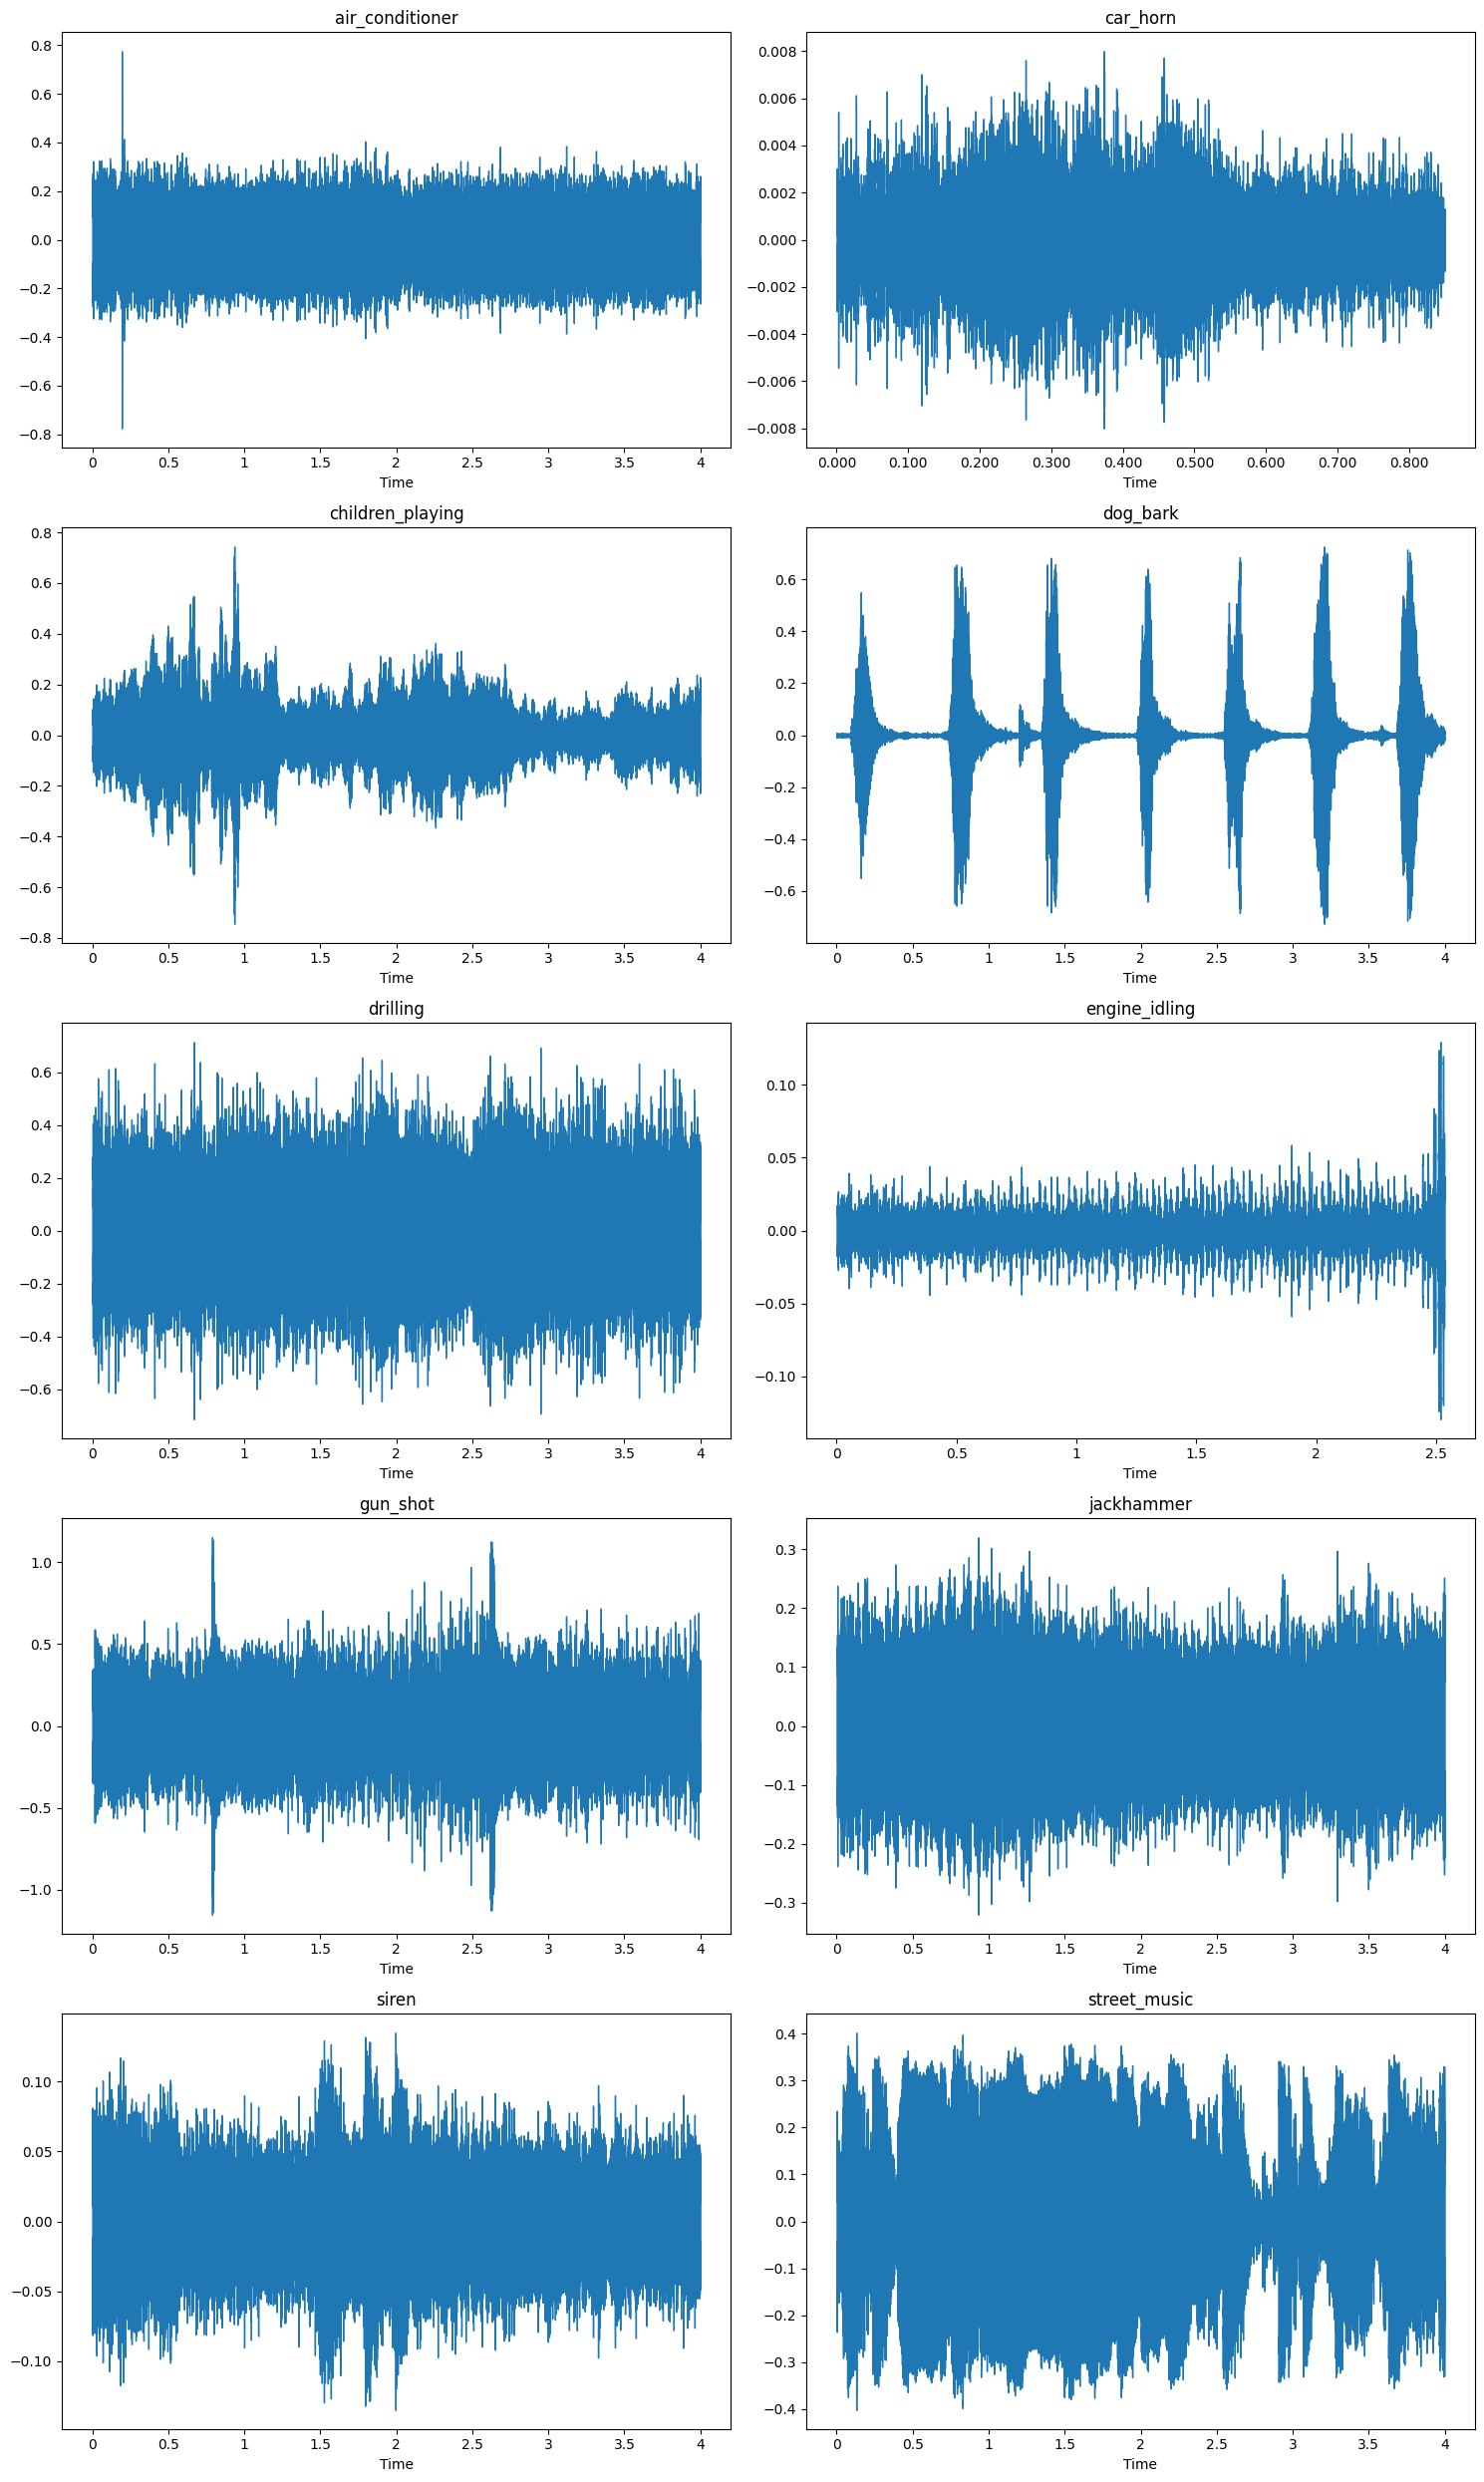

In [54]:
def plot_waveplots(df):
  # Randomly select one sample of each class
  random_samples = df.groupby('class').sample(1)
  audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

  # Number of samples and columns for the grid
  n_samples = len(random_samples)
  n_cols = 2
  n_rows = (n_samples + 1) // n_cols  # Ensure enough rows to accommodate all samples

  # Create a figure and axis objects
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

  # Flatten the axes array if more than one row
  if n_rows > 1:
      axs = axs.flatten()
  # Plot each audio sample in the grid
  for index, ax in enumerate(axs):
      if index < n_samples:
          audio_file, sample_rate = librosa.load(audio_samples[index])
          librosa.display.waveshow(audio_file, sr=sample_rate, ax=ax)
          ax.set_title('{}'.format(labels[index]))
      else:
          ax.axis('off')  # Hide unused subplots

  fig.tight_layout()
  plt.show()

plot_waveplots(df)

### STFT (log y-axis)

STFT (Short-Term Fourier Transform)

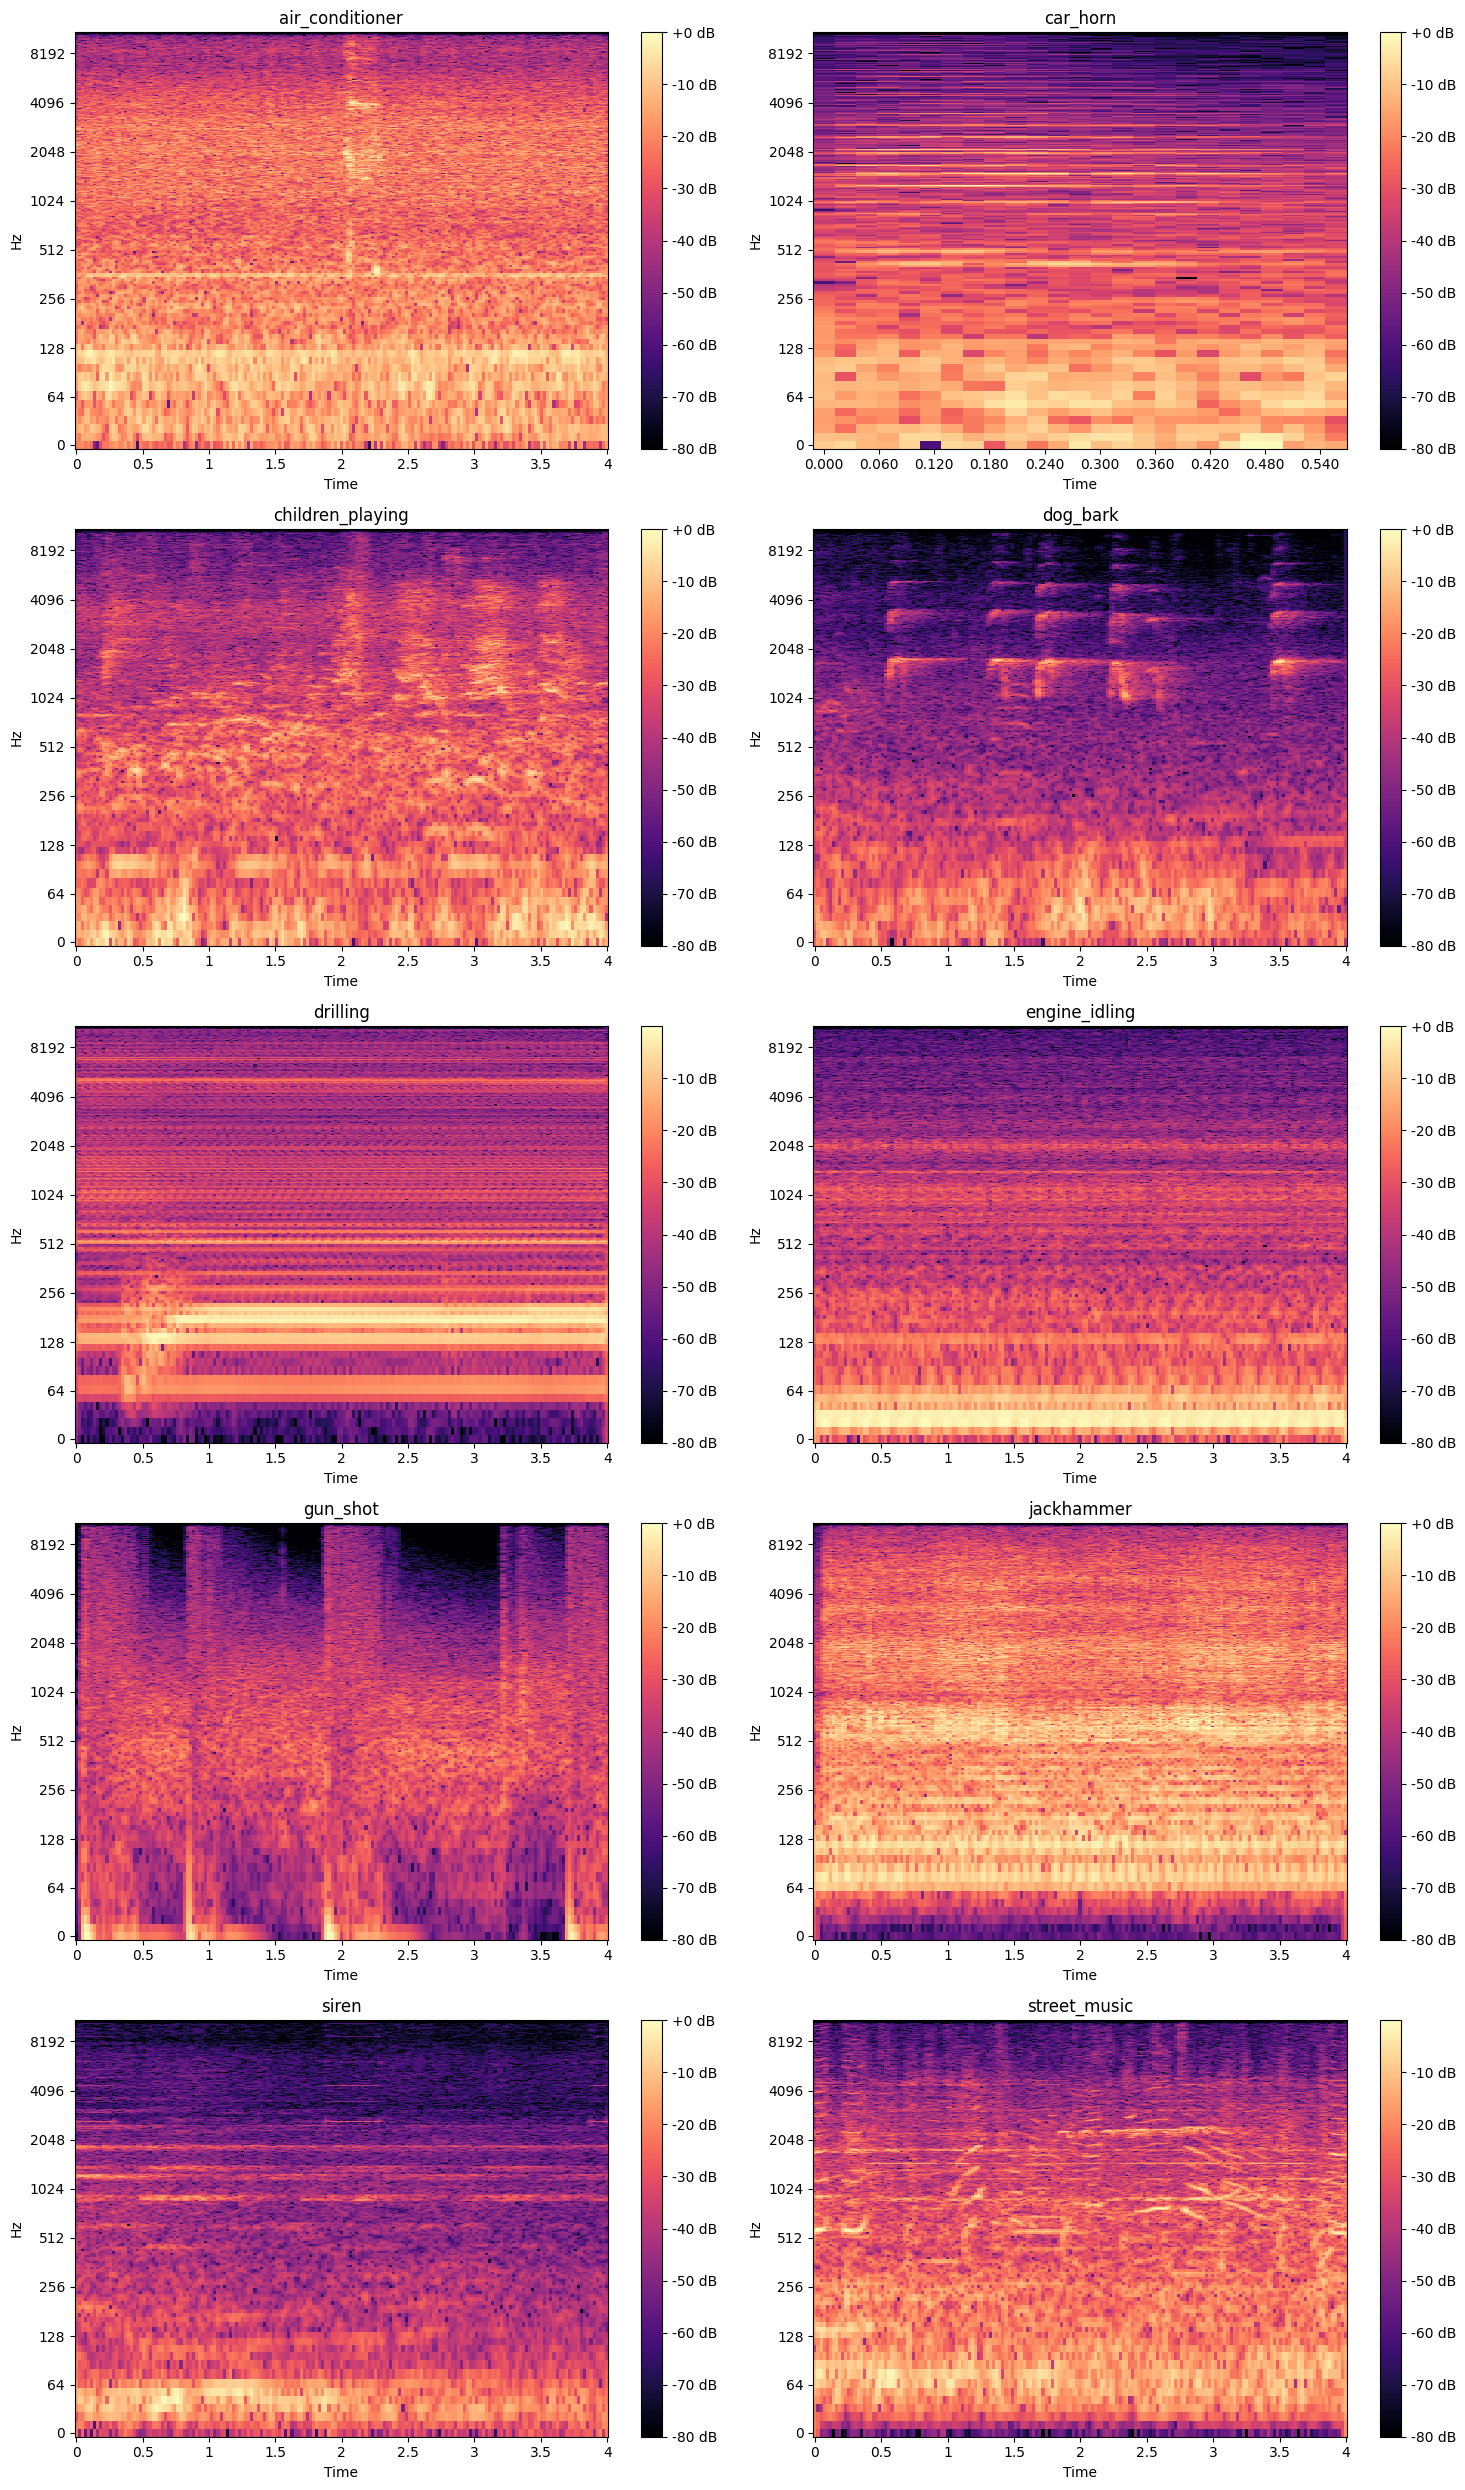

In [55]:
def plot_sfst(df):
    # Randomly select one sample of each class
    random_samples = df.groupby('class').sample(1)
    audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()
    n_fft = 2048
    hop_length = 512

    # Number of samples and columns for the grid
    n_samples = len(random_samples)
    n_cols = 2
    n_rows = (n_samples + 1) // n_cols  # Ensure enough rows to accommodate all samples

    # Create a figure and axis objects
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

    # Flatten the axes array if more than one row
    if n_rows > 1:
        axs = axs.flatten()

    # Plot each audio sample in the grid
    for index, ax in enumerate(axs):
        if index < n_samples:
            audio_file, sample_rate = librosa.load(audio_samples[index])
            stft = librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length)  # STFT of y
            S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
            img = librosa.display.specshow(S_db,
                                           n_fft=n_fft,
                                           sr=sample_rate,
                                           hop_length=hop_length,
                                           x_axis="time",
                                           y_axis='log',
                                           ax=ax)
            ax.set_title('{}'.format(labels[index]))
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')  # Hide unused subplots

    fig.tight_layout()
    plt.show()

plot_sfst(df)

### Mel-Spectogram

Next we will visualize the Mel-Spectogram which is a representation of the different frequencies magnitudes at different timesteps. The frequency magnitude is transformed to be on the Mel Scale, that takes into account how humans perceive and process audio signals.

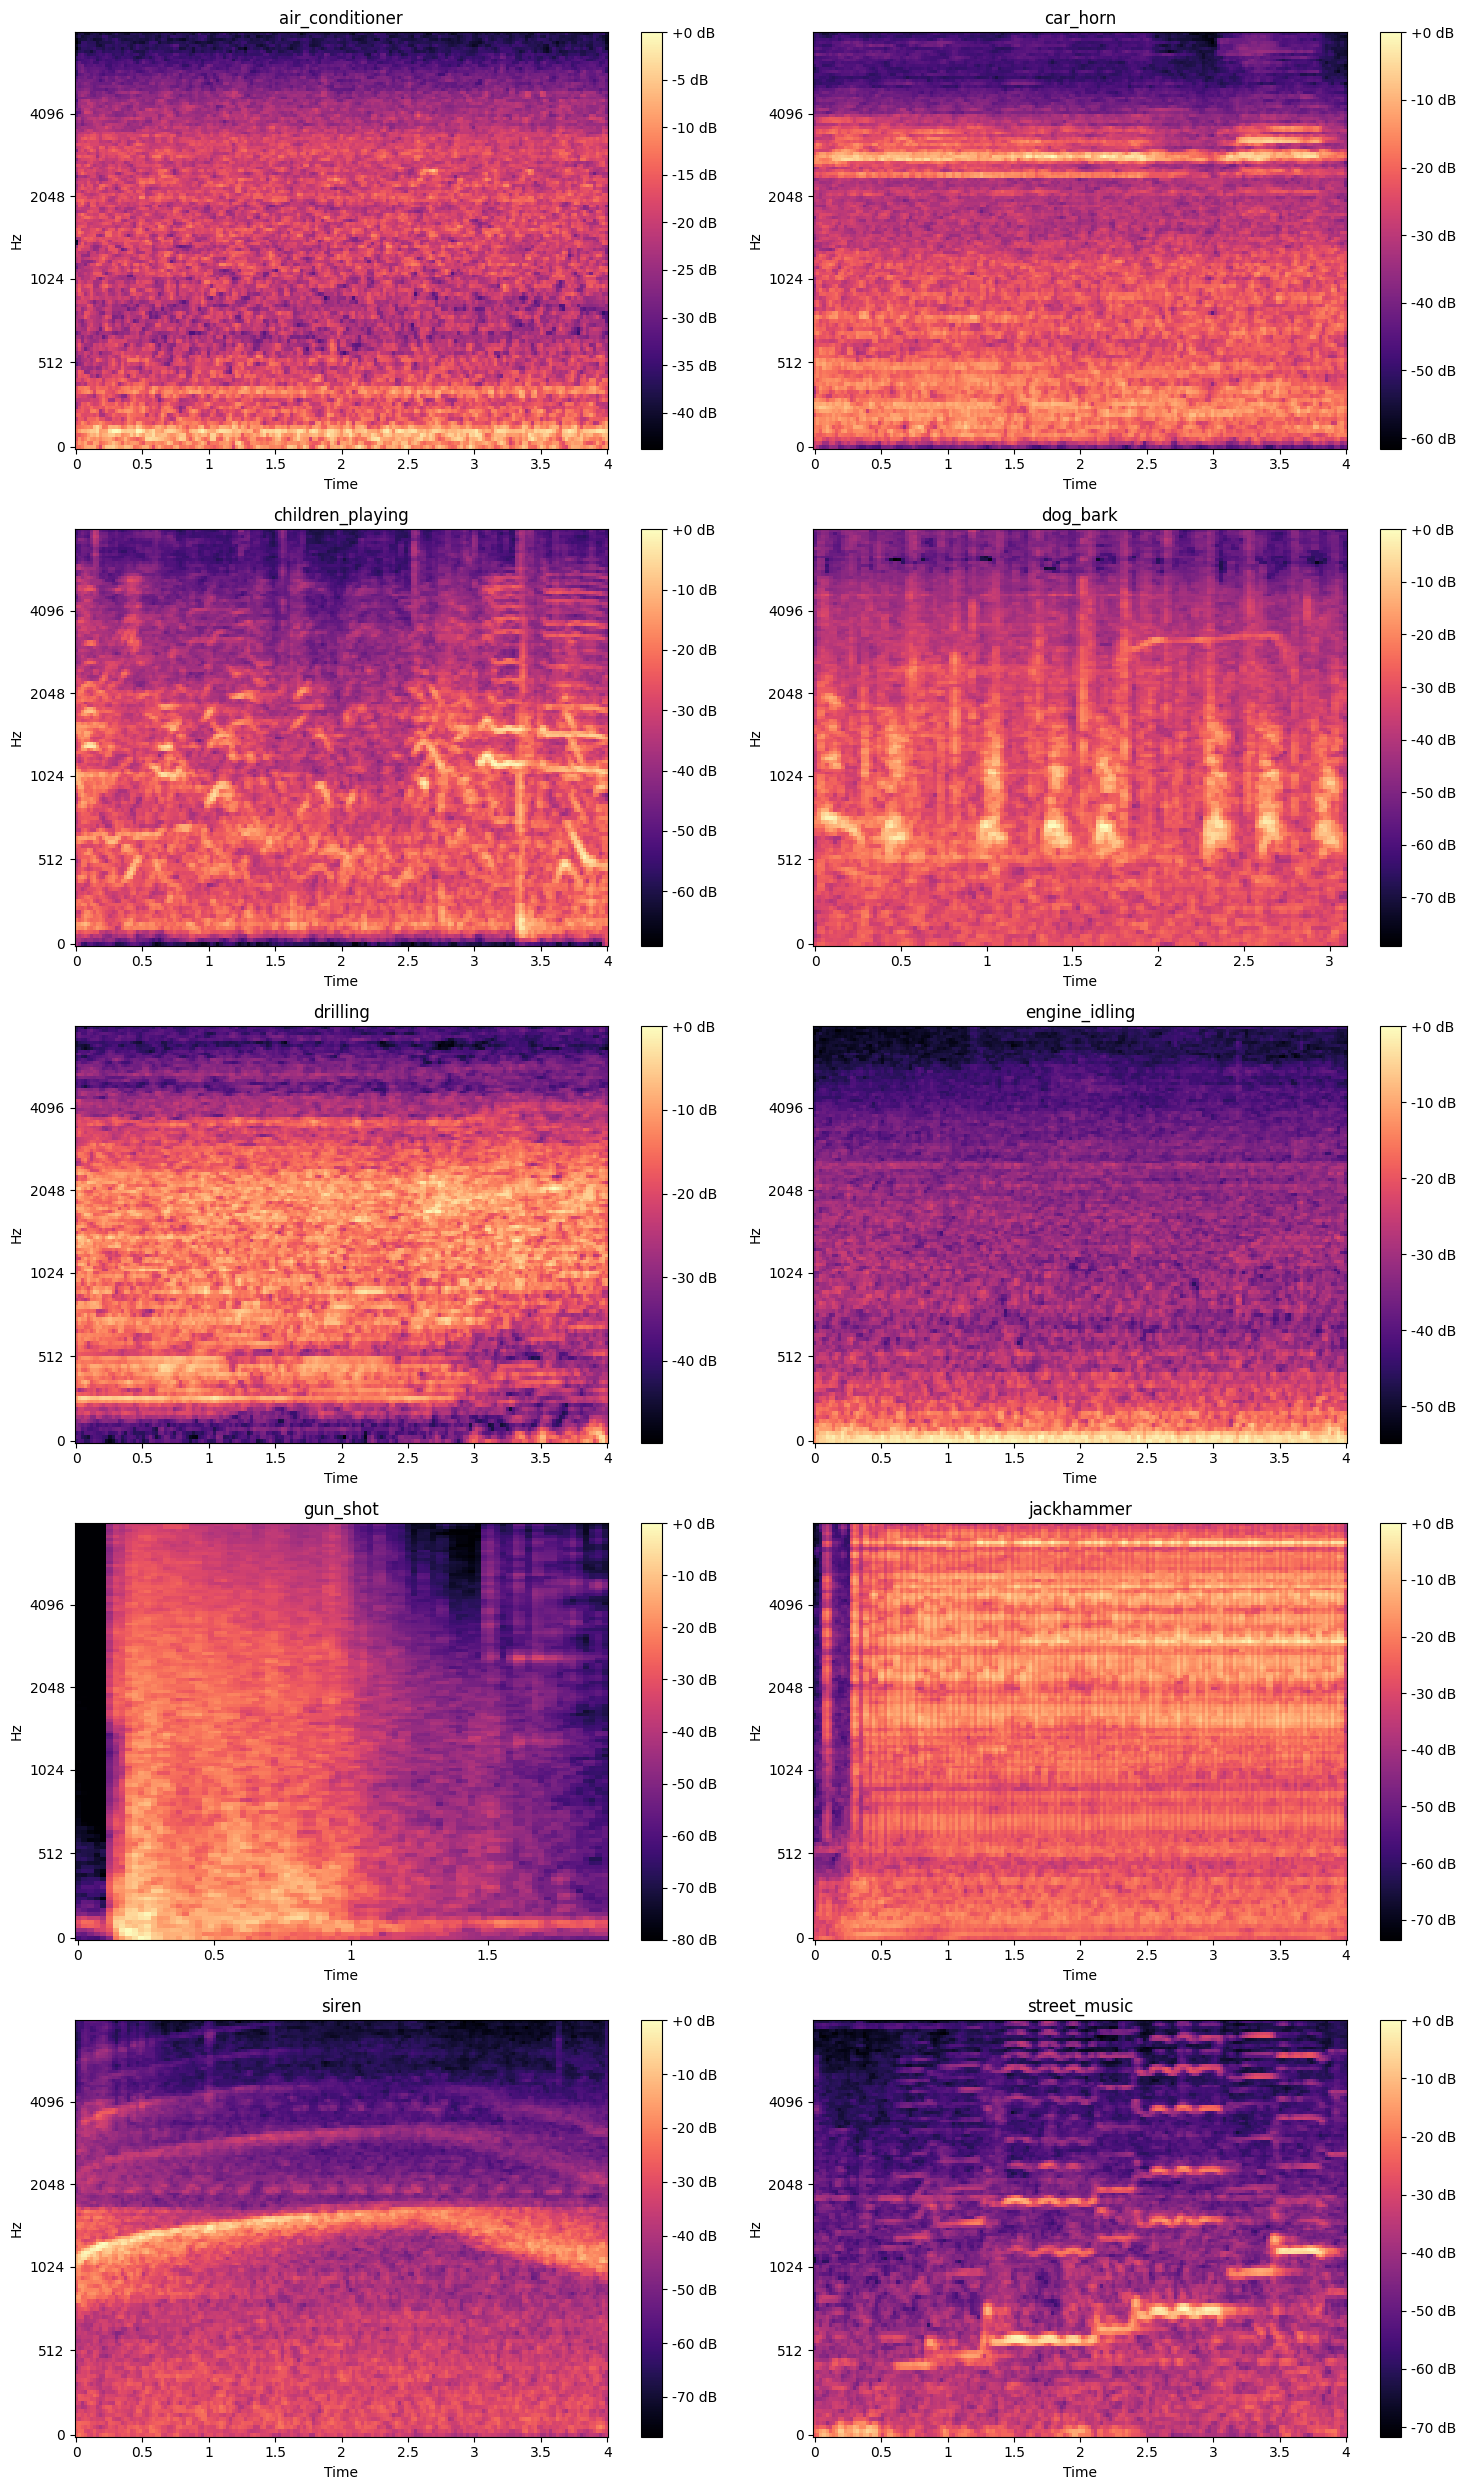

In [58]:
def plot_mel_spectofram(df):
    # Randomly select one sample of each class
    random_samples = df.groupby('class').sample(1)
    audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()
    n_fft = 2048
    hop_length = 512

    # Number of samples and columns for the grid
    n_samples = len(random_samples)
    n_cols = 2
    n_rows = (n_samples + 1) // n_cols  # Ensure enough rows to accommodate all samples

    # Create a figure and axis objects
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

    # Flatten the axes array if more than one row
    if n_rows > 1:
        axs = axs.flatten()

    # Plot each audio sample in the grid
    for index, ax in enumerate(axs):
        if index < n_samples:
            audio_file, sample_rate = librosa.load(audio_samples[index])
            S = librosa.feature.melspectrogram(y=audio_file, sr=sample_rate, n_mels=128, fmax=8000)
            S_dB = librosa.power_to_db(S, ref=np.max)
            img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000, ax=ax)
            ax.set_title('{}'.format(labels[index]))
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')  # Hide unused subplots

    fig.tight_layout()
    plt.show()

plot_mel_spectofram(df)

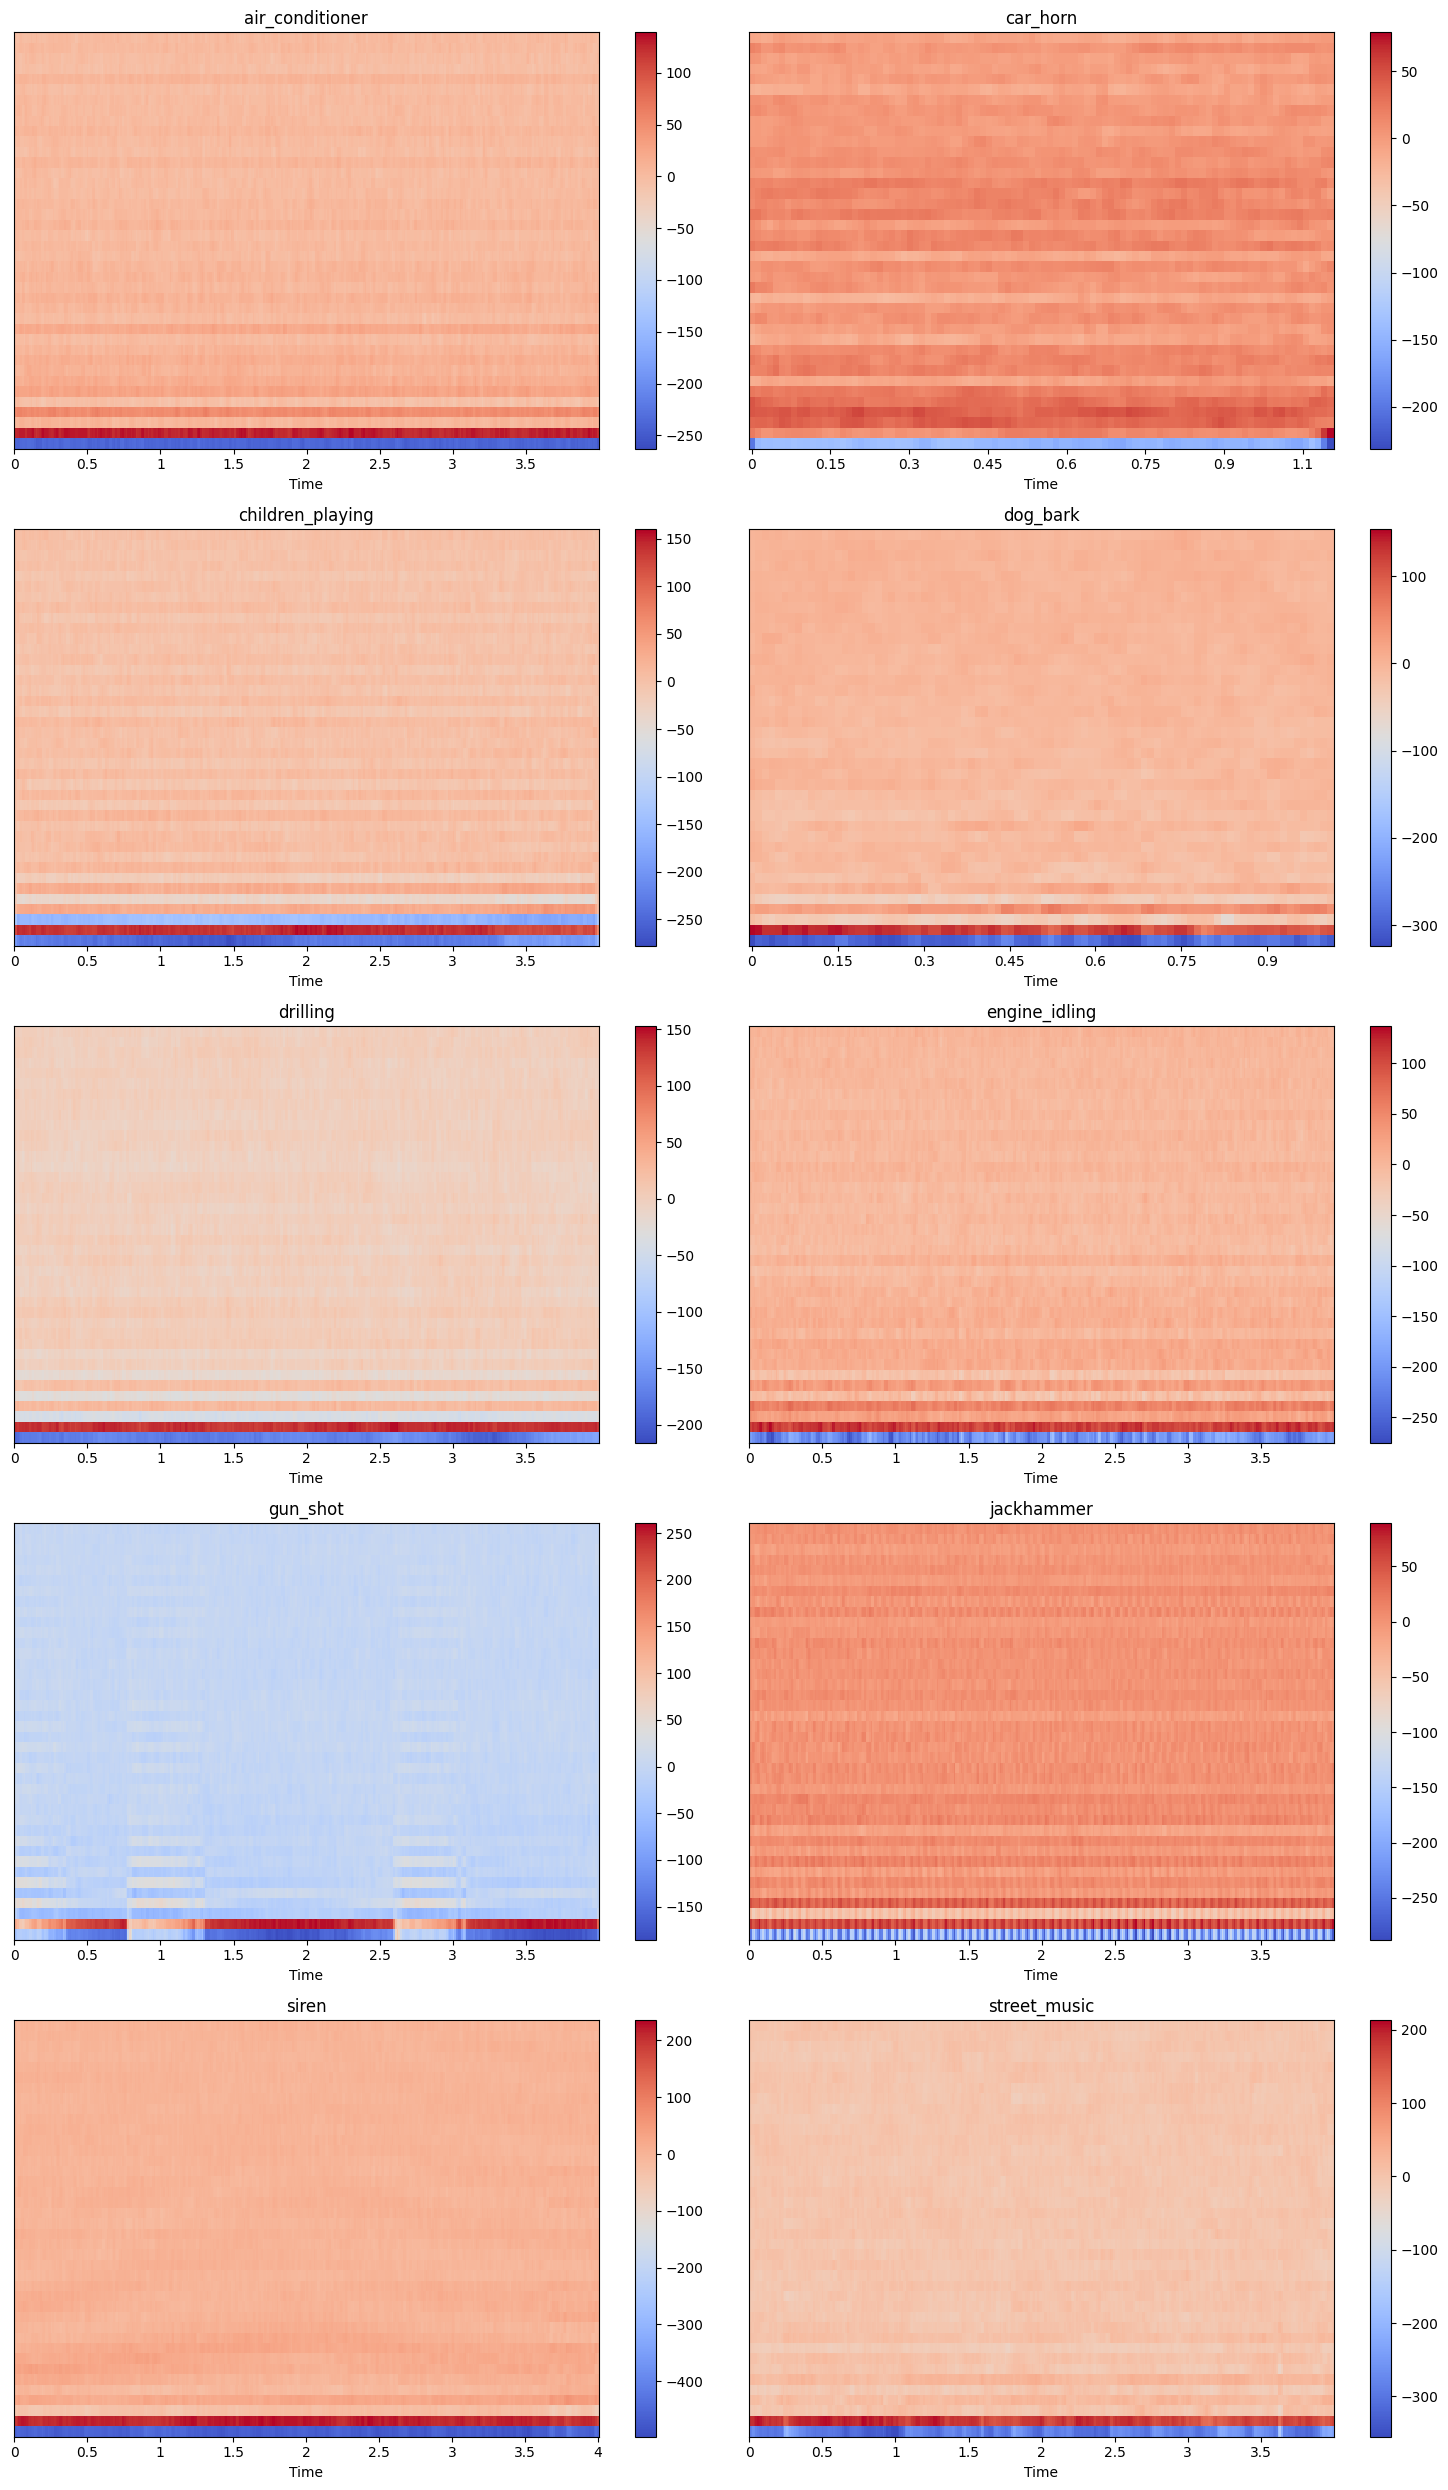

In [57]:
def plot_mfcc(df):
    # Randomly select one sample of each class
    random_samples = df.groupby('class').sample(1)
    audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()
    n_fft = 2048
    hop_length = 512

    # Number of samples and columns for the grid
    n_samples = len(random_samples)
    n_cols = 2
    n_rows = (n_samples + 1) // n_cols  # Ensure enough rows to accommodate all samples

    # Create a figure and axis objects
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

    # Flatten the axes array if more than one row
    if n_rows > 1:
        axs = axs.flatten()

    # Plot each audio sample in the grid
    for index, ax in enumerate(axs):
        if index < n_samples:
            audio_file, sample_rate = librosa.load(audio_samples[index], sr=None)
            mfccs = librosa.feature.mfcc(y=audio_file, sr=sample_rate, n_mfcc=40, n_fft=n_fft, hop_length=hop_length)
            img = librosa.display.specshow(mfccs,
                                           sr=sample_rate,
                                           hop_length=hop_length,
                                           x_axis="time",
                                           ax=ax)
            ax.set_title('{}'.format(labels[index]))
            fig.colorbar(img, ax=ax)
        else:
            ax.axis('off')  # Hide unused subplots

    fig.tight_layout()
    plt.show()

plot_mfcc(df)